# Capstone

## Toxicity Modeling

############################################################
# 1. IMPORTS & SETUP
############################################################

In [3]:
import pandas as pd
import numpy as np
import ast

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

############################################################
# 2. LOAD DATASET AND CLEAN THE DATASET
############################################################

In [5]:
df = pd.read_csv("C:/Users/annaj/Desktop/Python/Capstone/toxicity_w_bert_and_correct_labels.csv")

In [6]:
pd.set_option('display.max_columns', None)
df

,Unnamed: 0,index,unique_id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sentiment_score,toxic_word_count,emotions,anger,disgust,anticipation,fear,surprise,positive,joy,sadness,negative,trust,anticipation.1,left_vocab_count,right_vocab_count,Text Length,bert_embedding
0,0,0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...,1,0,1,0,1,0,-0.051786,5,"[('negative', 0.1590909090909091)]",0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.159091,0.000000,0,0,0,365,"[-0.38544198870658875, 0.3357332646846771, -0...."
1,1,1,0000247867823ef7,"from rfc the title is fine as it is, imo.",0,0,0,0,0,0,0.416667,0,"[('trust', 0.5), ('positive', 0.5)]",0.0,0.000000,0.0,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.500000,0,0,0,46,"[-0.30363142490386963, 0.061914704740047455, -..."
2,2,2,00013b17ad220c46,""" sources * zawe ashton on lapland / """,0,0,0,0,0,0,0.000000,0,"[('fear', 0.0), ('anger', 0.0), ('anticip', 0....",0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,49,"[-0.4227852523326874, 0.31722891330718994, -0...."
3,3,3,00017563c3f7919a,"if you have a look back at the source, the inf...",0,0,0,0,0,0,0.000000,0,"[('positive', 0.6666666666666666)]",0.0,0.000000,0.0,0.0,0.0,0.666667,0.000000,0.000000,0.000000,0.000000,0,0,0,205,"[-0.10063590109348297, -0.006853599101305008, ..."
4,4,4,00017695ad8997eb,i do not anonymously edit articles at all.,0,0,0,0,0,0,0.000000,0,"[('fear', 0.0), ('anger', 0.0), ('anticip', 0....",0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,42,"[-0.3968925178050995, 0.101864293217659, 0.069..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153159,153159,153159,fffcd0960ee309b5,". i totally agree, this stuff is nothing but...",0,0,0,0,0,0,0.000000,0,"[('positive', 1.0)]",0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,60,"[-0.6384586095809937, 0.20851817727088928, -0...."
153160,153160,153160,fffd7a9a6eb32c16,throw from out field to home plate. does ...,0,0,0,0,0,0,0.325000,0,"[('fear', 0.0), ('anger', 0.0), ('anticip', 0....",0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,194,"[-0.37261533737182617, 0.2313564419746399, -0...."
153161,153161,153161,fffda9e8d6fafa9e,""" okinotorishima categories i see your...",0,0,0,0,0,0,0.100000,0,"[('positive', 0.5)]",0.0,0.000000,0.0,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0,0,0,410,"[-0.19436338543891907, 0.09967486560344696, -0..."
153162,153162,153162,fffe8f1340a79fc2,""" """"one of the founding nations of the eu ...",0,0,0,0,0,0,0.047917,0,"[('trust', 0.6)]",0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.600000,0,0,0,499,"[-0.22779934108257294, 0.1979484260082245, -0...."


In [7]:
# Check for missing values in each DataFrame
df.isnull().sum()

Unnamed: 0            0
index                 0
unique_id             0
comment_text          9
toxic                 0
severe_toxic          0
obscene               0
threat                0
insult                0
identity_hate         0
sentiment_score       0
toxic_word_count      0
emotions              0
anger                 0
disgust               0
anticipation          0
fear                  0
surprise              0
positive              0
joy                   0
sadness               0
negative              0
trust                 0
anticipation.1        0
left_vocab_count      0
right_vocab_count     0
Text Length           0
bert_embedding       72
dtype: int64

In [8]:
# Handle missing values
df.dropna(inplace=True)
df.isnull().sum().sum()

0

In [9]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'index', 'unique_id'], inplace=True)

In [10]:
print(f"Columns in df:")
print(df.columns.tolist())

Columns in df:
['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sentiment_score', 'toxic_word_count', 'emotions', 'anger', 'disgust', 'anticipation', 'fear', 'surprise', 'positive', 'joy', 'sadness', 'negative', 'trust', 'anticipation.1', 'left_vocab_count', 'right_vocab_count', 'Text Length', 'bert_embedding']


In [18]:
# Quick statistical summaries
print("Summary of df:")
display(df.describe())

Summary of df:


,toxic,severe_toxic,obscene,threat,insult,identity_hate,sentiment_score,toxic_word_count,anger,disgust,anticipation,fear,surprise,positive,joy,sadness,negative,trust,anticipation.1,left_vocab_count,right_vocab_count,Text Length
count,153083.000000,153083.000000,153083.000000,153083.000000,153083.00000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.000000,153083.0,153083.000000,153083.000000,153083.000000
mean,0.122123,0.003227,0.078755,0.001731,0.06341,0.009544,0.034947,0.608983,0.019143,0.020364,0.034698,0.024966,0.009755,0.187209,0.013171,0.019013,0.125087,0.067272,0.0,0.055604,0.051031,355.136802
std,0.327429,0.056715,0.269356,0.041570,0.24370,0.097226,0.263585,11.156536,0.073552,0.080076,0.126325,0.093690,0.063512,0.255271,0.060064,0.072962,0.217274,0.167638,0.0,0.288017,0.264891,576.836538
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.025591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,75.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,175.000000
75%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.162500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.222222,0.000000,0.0,0.000000,0.000000,384.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,15.000000,8.000000,5091.000000


# Merge all toxicity labels into a single "toxic" column

In [21]:
# Merge all toxicity labels into a single "toxic" column
df['toxic'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

# Drop the other columns as they are now merged
df.drop(columns=['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], inplace=True)

print("Updated Columns:", df.columns)

Updated Columns: Index(['comment_text', 'toxic', 'sentiment_score', 'toxic_word_count',
       'emotions', 'anger', 'disgust', 'anticipation', 'fear', 'surprise',
       'positive', 'joy', 'sadness', 'negative', 'trust', 'anticipation.1',
       'left_vocab_count', 'right_vocab_count', 'Text Length',
       'bert_embedding'],
      dtype='object')


############################################################
# 3.1. CONVERT BERT EMBEDDINGS FROM STRING TO FLOATS [X_bert]
############################################################

In [26]:
# 1) Convert BERT embeddings from string ("[0.12, -0.33, ...]") to a list of floats
df['bert_embedding'] = df['bert_embedding'].apply(ast.literal_eval)

# 2) Convert BERT embeddings into a NumPy array
X_bert = np.array(df['bert_embedding'].tolist())
print("BERT embedding shape:", X_bert.shape)


BERT embedding shape: (153083, 312)


# Save this dataframe as a new csv file

In [25]:
# df.to_csv("toxicity_w_bert_Feb11.csv", index=False)

############################################################
# 3.2. TF-IDF vectorization on comment_text and Combined with Bert Embedding [X_combined]
############################################################

In [32]:
# 3) TF-IDF vectorization on comment_text
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['comment_text'].astype(str))
print("TF-IDF shape:", X_tfidf.shape)  # e.g. (num_samples, 5000)

# 4) Combine TF-IDF and BERT embeddings into one feature matrix
X_combined = hstack([X_tfidf, csr_matrix(X_bert)]) 
print("Combined feature shape:", X_combined.shape)


TF-IDF shape: (153083, 5000)
Combined feature shape: (153083, 5312)


############################################################
# 4. Feature Column and Target Column
############################################################

In [60]:
target_col = 'toxic'
X = X_tfidf
# X = X_combined # combination of two columns => 'bert_embedding' + 'comment_text'
y = df[target_col].values

In [62]:
print(X.shape)


(153083, 5000)


############################################################
# 5.1. Train, Validate and Test Split, TRAIN THE MODEL AND EVALUATE
############################################################
## Train & Validation Sets

=== Model: LogisticRegression ===

Test Set Metrics for LogisticRegression:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     26825
           1       0.57      0.90      0.70      3792

    accuracy                           0.90     30617
   macro avg       0.78      0.90      0.82     30617
weighted avg       0.93      0.90      0.91     30617

Confusion Matrix (Test Set):
[[24279  2546]
 [  372  3420]]
AUC-ROC Score (Test Set): 0.9687

--------------------------------------------------

=== Model: RandomForest ===

Test Set Metrics for RandomForest:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     26825
           1       0.71      0.84      0.77      3792

    accuracy                           0.94     30617
   macro avg       0.84      0.89      0.86     30617
weighted avg       0.94      0.94      0.94     30617

Confusion Matrix (Test Set):
[[25504  1321]
 [  618  3174]]


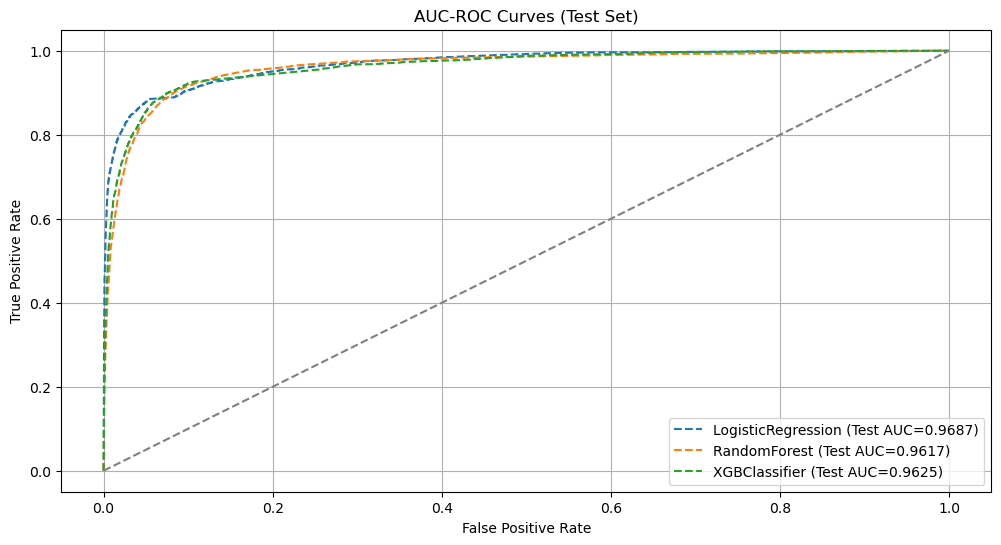

In [64]:

# Step 1: Split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Apply SMOTE on the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define models
models = {
    "LogisticRegression": LogisticRegression(
        random_state=42, max_iter=1000
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, random_state=42, bootstrap=True, n_jobs=-1
    ),
    "XGBClassifier": XGBClassifier(
        eval_metric='logloss', random_state=42, n_jobs=-1
    )
}

# Train and Evaluate Models on Test Set
plt.figure(figsize=(12, 6))

for model_name, model in models.items():
    print(f"=== Model: {model_name} ===")

    # Train model on resampled training set
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on Test Set
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print(f"\nTest Set Metrics for {model_name}:")
    print(classification_report(y_test, y_test_pred))
    print("Confusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_test_pred))

    # AUC-ROC
    auc_roc_test = roc_auc_score(y_test, y_test_pred_proba)
    print(f"AUC-ROC Score (Test Set): {auc_roc_test:.4f}")

    # ROC Curve
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
    plt.plot(fpr_test, tpr_test, linestyle="--", label=f"{model_name} (Test AUC={auc_roc_test:.4f})")

    print("\n" + "-"*50 + "\n")

# Finalize Plot
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# 5.2. PREDICT ON TEST SET AND EVALUATE 
## TEST set

In [66]:
# === Evaluate Best Model on the Test Set ===
print("=== Final Test Evaluation for Best Model ===")
best_model = models["RandomForest"] 
print(f"Model: {best_model.__class__.__name__}")

=== Final Test Evaluation for Best Model ===
Model: RandomForestClassifier


In [52]:
"""
# Predict on Test Set
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print Test Metrics
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Compute AUC-ROC
auc_roc_test = roc_auc_score(y_test, y_test_pred_proba)
print(f"AUC-ROC Score (Test Set): {auc_roc_test:.4f}")

# Plot ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f"{best_model.__class__.__name__} (AUC={auc_roc_test:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()
"""

'\n# Predict on Test Set\ny_test_pred = best_model.predict(X_test)\ny_test_pred_proba = best_model.predict_proba(X_test)[:, 1]\n\n# Print Test Metrics\nprint(classification_report(y_test, y_test_pred))\nprint("Confusion Matrix (Test Set):")\nprint(confusion_matrix(y_test, y_test_pred))\n\n# Compute AUC-ROC\nauc_roc_test = roc_auc_score(y_test, y_test_pred_proba)\nprint(f"AUC-ROC Score (Test Set): {auc_roc_test:.4f}")\n\n# Plot ROC Curve\nfpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)\nplt.figure(figsize=(8, 6))\nplt.plot(fpr_test, tpr_test, label=f"{best_model.__class__.__name__} (AUC={auc_roc_test:.4f})")\nplt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line\nplt.xlabel("False Positive Rate")\nplt.ylabel("True Positive Rate")\nplt.title("AUC-ROC Curve (Test Set)")\nplt.legend()\nplt.grid(True)\nplt.show()\n'

# Saving Model

In [70]:
import zipfile
import joblib
# Save the trained logistic regression model
joblib.dump(models["RandomForest"], "toxicity_model.pkl")
print("RandomForest model saved as 'toxicity_model.pkl'")

# Save the TF-IDF vectorizer used during training
joblib.dump(tfidf, "Preprocessing.pkl")
print("TF-IDF vectorizer saved as 'Preprocessing.pkl'")


# Define filenames
model_filename = "toxicity_model.pkl"
vectorizer_filename = "Preprocessing.pkl"
zip_filename = "toxicity_model_pack.zip"

# Create zip file
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(model_filename)
    zipf.write(vectorizer_filename)

print(f"Created zip file: {zip_filename}")



RandomForest model saved as 'toxicity_model.pkl'
TF-IDF vectorizer saved as 'Preprocessing.pkl'
Created zip file: toxicity_model_pack.zip
